## Libraries

In [1]:
!pip install datasets==2.15
sample = 1000

ERROR: Could not find a version that satisfies the requirement datasets==2.15 (from versions: none)
ERROR: No matching distribution found for datasets==2.15


In [2]:
# Importing necessary libraries
import nltk
import numpy as np # linear algebra
import lightgbm as lgb
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from lightgbm import log_evaluation, early_stopping
from sklearn.linear_model import SGDClassifier
import polars as pl
import torch
from IPython.display import display
from datasets import Dataset,DatasetDict
from transformers import AutoTokenizer
from transformers import AutoModel

nltk.download('wordnet')

[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

### Reading the Data

In [3]:
columns = [  
    (
        pl.col("full_text").str.split(by="\n\n").alias("paragraph")
    ),
]
PATH = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/"
# 载入训练集和测试集，同时对full_text数据使用\n\n字符分割为列表，重命名为paragraph
# Load training and testing sets, while using \ n \ n character segmentation to list and renaming to paragraph for full_text data
train = pl.read_csv(PATH + "train.csv").with_columns(columns)

# for test only
#train = train.sample(sample)
test = pl.read_csv(PATH + "test.csv").with_columns(columns)
# 显示训练集中的第一个样本数据
# Display the first sample data in the training set
train.head(1)

essay_id,full_text,score,paragraph
str,str,i64,list[str]
"""000d118""","""Many people ha…",3,"[""Many people have car where they live. The thing they don't know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban's families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the French and Swiss borders. You probaly won't see a car in Vauban's streets because they are completely ""car free"" but If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a home. The vauban people completed this in 2006 ,they said that this an example of a growing trend in Europe,The untile states and some where else are suburban life from auto use this is called ""smart planning"". The current efforts to drastically reduce greenhouse gas emissions from tailes the passengee cars are responsible for 12 percent of greenhouse gas emissions in Europe and up to 50 percent in some car intensive in the United States. I honeslty think that good idea that they did that is Vaudan because that makes cities denser and better for walking and in VAUBAN there are 5,500 residents within a rectangular square mile. In the artical David Gold berg said that ""All of our development since World war 2 has been centered on the cars,and that will have to change"" and i think that was very true what David Gold said because alot thing we need cars to do we can go anyway were with out cars beacuse some people are a very lazy to walk to place thats why they alot of people use car and i think that it was a good idea that that they did that in VAUBAN so people can see how we really don't need car to go to place from place because we can walk from were we need to go or we can ride bycles with out the use of a car. It good that they are doing that if you thik about your help the earth in way and thats a very good thing to. In the United states ,the Environmental protection Agency is promoting what is called ""car reduced""communtunties,and the legislators are starting to act,if cautiously. Maany experts expect pubic transport serving suburbs to play a much larger role in a new six years federal transportation bill to approved this year. In previous bill,80 percent of appropriations have by law gone to highways and only 20 percent to other transports. There many good reason why they should do this. ""]"


### Preprocessing 

In [4]:
def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)
def dataPreprocessing(x):
    # 将单词转化为小写
    # Convert words to lowercase
    x = x.lower()
    # Remove HTML
    # 移除html
    x = removeHTML(x)
    # 删除以@作为首字母的字符串
    # Delete strings starting with @
    x = re.sub("@\w+", '',x)
    # 删除数字
    # Delete Numbers
    x = re.sub("'\d+", '',x) # can delete it
    x = re.sub("\d+", '',x)
    # 删除网址
    # Delete URL
    x = re.sub("http\w+", '',x)
    # 将连续空白符替换为一个空格字符
    # Replace consecutive empty spaces with a single space character
    x = re.sub(r"\s+", " ", x)
    # 替换连续的句号和逗号为一个
    # Replace consecutive commas and periods with one comma and period character
    x = re.sub(r"\.+", ".", x)
    x = re.sub(r"\,+", ",", x)
    # 去除开头结尾的空白符
    # Remove empty characters at the beginning and end
    x = x.strip()
    return x

### evaluation and Loss function

In [5]:
# evaluation metric.
# idea from https://www.kaggle.com/code/rsakata/optimize-qwk-by-lgb/notebook#QWK-objective
def quadratic_weighted_kappa(y_true, y_pred):
    y_true = y_true + a
    y_pred = (y_pred + a).clip(1, 6).round()
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    return 'QWK', qwk, True

# Loss function
def qwk_obj(y_true, y_pred):
    labels = y_true + a
    preds = y_pred + a
    preds = preds.clip(1, 6)
    f = 1/2*np.sum((preds-labels)**2)
    g = 1/2*np.sum((preds-a)**2+b)
    df = preds - labels
    dg = preds - a
    grad = (df/g - f*dg/g**2)*len(labels)
    hess = np.ones(len(labels))
    return grad, hess
a = 2.948
b = 1.092

### Feature extraction

In [6]:
# convert the df to dataset 
train = train.with_columns(pl.col('full_text').map_elements(dataPreprocessing,return_dtype=str))
test = test.with_columns(pl.col('full_text').map_elements(dataPreprocessing,return_dtype=str))

ds_train = Dataset.from_pandas(train.to_pandas())
ds_test = Dataset.from_pandas(test.to_pandas())

ds = DatasetDict({"train": ds_train, "test": ds_test})

# Print the dataset dictionary keys and sizes
for name, dataset in ds.items():
    print(f"{name} size:", len(dataset))


train size: 17307
test size: 3


In [7]:
# tokenize 
model_ckpt = "/kaggle/input/deberta-v3/pytorch/base/2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["full_text"], padding=True)

dst = ds.map(tokenize, batched=True ,batch_size = 64)
print(dst)

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/17307 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['essay_id', 'full_text', 'score', 'paragraph', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 17307
    })
    test: Dataset({
        features: ['essay_id', 'full_text', 'paragraph', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3
    })
})


In [8]:
# load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [9]:
# set format to tensors, ( needed for the model Feedforward )
dst.set_format("torch",columns=["input_ids", "attention_mask"])

# remove unwanted features
columns_to_remove = ['essay_id', 'full_text', 'paragraph']
dstr = dst.remove_columns(columns_to_remove)

In [10]:
# extract the features
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

# prepare the vectors
dstr_hidden = dstr.map(extract_hidden_states,batched=True,batch_size = 2)

Map:   0%|          | 0/17307 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

### modeling

In [11]:
X = dstr_hidden['train']['hidden_state'].numpy()
y_split = np.array(dstr_hidden['train']['score'])
y = y_split-a

fold 1


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.728962	valid's QWK: 0.70665
[50]	train's QWK: 0.759031	valid's QWK: 0.735247
[75]	train's QWK: 0.773481	valid's QWK: 0.746341
[100]	train's QWK: 0.783468	valid's QWK: 0.753552
[125]	train's QWK: 0.791071	valid's QWK: 0.753814
[150]	train's QWK: 0.797757	valid's QWK: 0.75573
[175]	train's QWK: 0.802992	valid's QWK: 0.760557
[200]	train's QWK: 0.807296	valid's QWK: 0.762084
[225]	train's QWK: 0.811219	valid's QWK: 0.765187
[250]	train's QWK: 0.815333	valid's QWK: 0.767152
[275]	train's QWK: 0.818371	valid's QWK: 0.763799
[300]	train's QWK: 0.821491	valid's QWK: 0.764505
Early stopping, best iteration is:
[244]	train's QWK: 0.814477	valid's QWK: 0.767965
Evaluated only: QWK


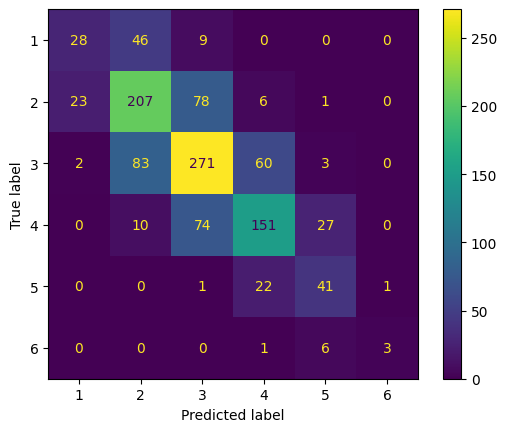

F1 score across fold: 0.6041519690031635
Cohen kappa score across fold: 0.7679650910519107
fold 2
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.73191	valid's QWK: 0.714074
[50]	train's QWK: 0.759504	valid's QWK: 0.739449
[75]	train's QWK: 0.77281	valid's QWK: 0.751736
[100]	train's QWK: 0.783509	valid's QWK: 0.761037
[125]	train's QWK: 0.789632	valid's QWK: 0.766012
[150]	train's QWK: 0.796063	valid's QWK: 0.771318
[175]	train's QWK: 0.801377	valid's QWK: 0.767753
[200]	train's QWK: 0.806602	valid's QWK: 0.772028
[225]	train's QWK: 0.810639	valid's QWK: 0.771928
[250]	train's QWK: 0.814499	valid's QWK: 0.773885
[275]	train's QWK: 0.818822	valid's QWK: 0.772986
[300]	train's QWK: 0.823273	valid's QWK: 0.772375
[325]	train's QWK: 0.826859	valid's QWK: 0.774843
[350]	train's QWK: 0.829739	valid's QWK: 0.774967
[375]	train's QWK: 0.832495	valid's QWK: 0.772679
[400]	train's QWK: 0.836672	valid's QWK:

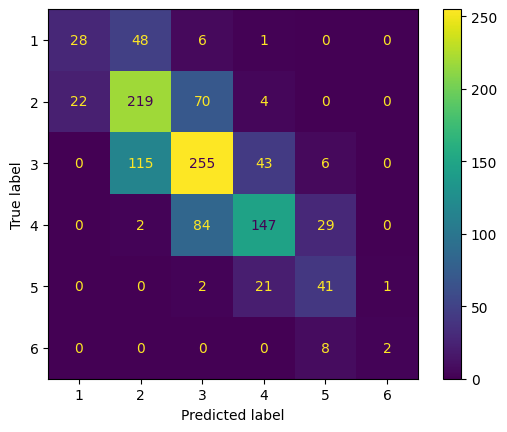

F1 score across fold: 0.596130475900324
Cohen kappa score across fold: 0.7803286342821226
fold 3
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.735224	valid's QWK: 0.717021
[50]	train's QWK: 0.761318	valid's QWK: 0.745126
[75]	train's QWK: 0.775228	valid's QWK: 0.758628
[100]	train's QWK: 0.784228	valid's QWK: 0.763782
[125]	train's QWK: 0.790858	valid's QWK: 0.766482
[150]	train's QWK: 0.797607	valid's QWK: 0.772153
[175]	train's QWK: 0.802034	valid's QWK: 0.774021
[200]	train's QWK: 0.80691	valid's QWK: 0.777252
[225]	train's QWK: 0.811868	valid's QWK: 0.776273
[250]	train's QWK: 0.816348	valid's QWK: 0.777076
[275]	train's QWK: 0.820581	valid's QWK: 0.778257
[300]	train's QWK: 0.824604	valid's QWK: 0.778991
[325]	train's QWK: 0.828427	valid's QWK: 0.779085
Early stopping, best iteration is:
[270]	train's QWK: 0.819389	valid's QWK: 0.78129
Evaluated only: QWK


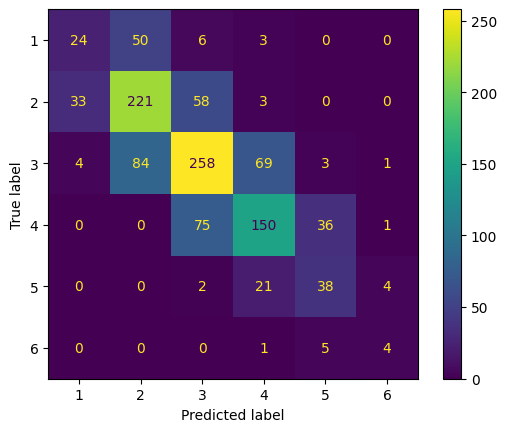

F1 score across fold: 0.5994857709466967
Cohen kappa score across fold: 0.7812900931243968
fold 4
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.731691	valid's QWK: 0.744678
[50]	train's QWK: 0.758701	valid's QWK: 0.760126
[75]	train's QWK: 0.772302	valid's QWK: 0.768163
[100]	train's QWK: 0.78401	valid's QWK: 0.76963
[125]	train's QWK: 0.789696	valid's QWK: 0.772191
[150]	train's QWK: 0.796479	valid's QWK: 0.773487
[175]	train's QWK: 0.801951	valid's QWK: 0.770015
[200]	train's QWK: 0.806564	valid's QWK: 0.770294
[225]	train's QWK: 0.810726	valid's QWK: 0.769957
Early stopping, best iteration is:
[158]	train's QWK: 0.797362	valid's QWK: 0.775497
Evaluated only: QWK


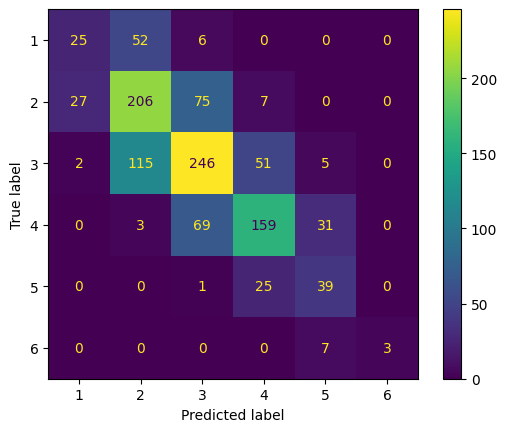

F1 score across fold: 0.5850552766923756
Cohen kappa score across fold: 0.7754967428155564
fold 5
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.732312	valid's QWK: 0.73164
[50]	train's QWK: 0.759194	valid's QWK: 0.758424
[75]	train's QWK: 0.773117	valid's QWK: 0.761136
[100]	train's QWK: 0.781851	valid's QWK: 0.764079
[125]	train's QWK: 0.79111	valid's QWK: 0.763995
[150]	train's QWK: 0.79717	valid's QWK: 0.769237
[175]	train's QWK: 0.803095	valid's QWK: 0.771978
[200]	train's QWK: 0.807619	valid's QWK: 0.772637
[225]	train's QWK: 0.811644	valid's QWK: 0.774973
[250]	train's QWK: 0.815565	valid's QWK: 0.77483
[275]	train's QWK: 0.819593	valid's QWK: 0.775479
[300]	train's QWK: 0.822723	valid's QWK: 0.775458
[325]	train's QWK: 0.826872	valid's QWK: 0.775683
[350]	train's QWK: 0.830376	valid's QWK: 0.774443
[375]	train's QWK: 0.833901	valid's QWK: 0.770992
Early stopping, best iteration is:
[312]	t

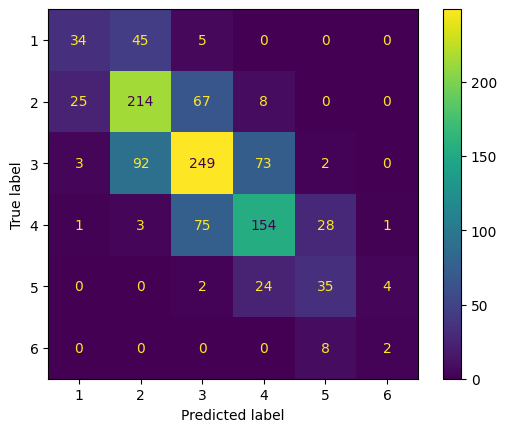

F1 score across fold: 0.5941540106628487
Cohen kappa score across fold: 0.7795172982362336
fold 6
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.728718	valid's QWK: 0.750106
[50]	train's QWK: 0.758181	valid's QWK: 0.771431
[75]	train's QWK: 0.775621	valid's QWK: 0.777679
[100]	train's QWK: 0.783872	valid's QWK: 0.778724
[125]	train's QWK: 0.788876	valid's QWK: 0.778324
[150]	train's QWK: 0.795906	valid's QWK: 0.778899
Early stopping, best iteration is:
[95]	train's QWK: 0.782635	valid's QWK: 0.780222
Evaluated only: QWK


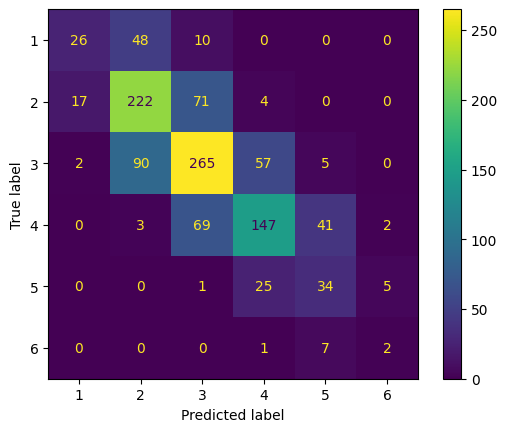

F1 score across fold: 0.5998502701243741
Cohen kappa score across fold: 0.7802222978082246
fold 7
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.732608	valid's QWK: 0.725449
[50]	train's QWK: 0.759553	valid's QWK: 0.737805
[75]	train's QWK: 0.773428	valid's QWK: 0.74158
[100]	train's QWK: 0.783118	valid's QWK: 0.756243
[125]	train's QWK: 0.789946	valid's QWK: 0.766078
[150]	train's QWK: 0.79681	valid's QWK: 0.764479
[175]	train's QWK: 0.800534	valid's QWK: 0.76879
[200]	train's QWK: 0.806831	valid's QWK: 0.769828
[225]	train's QWK: 0.810778	valid's QWK: 0.771472
[250]	train's QWK: 0.815471	valid's QWK: 0.771421
[275]	train's QWK: 0.818331	valid's QWK: 0.77042
Early stopping, best iteration is:
[218]	train's QWK: 0.80961	valid's QWK: 0.773387
Evaluated only: QWK


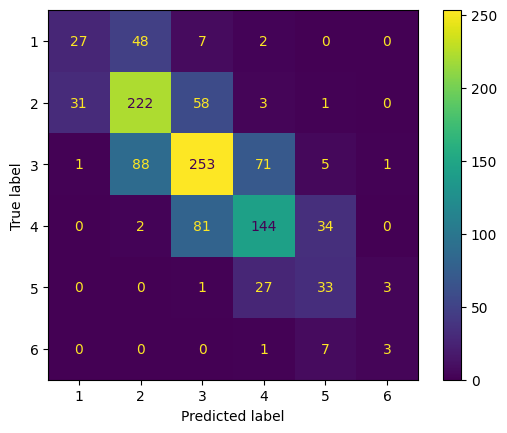

F1 score across fold: 0.587926717674788
Cohen kappa score across fold: 0.773386562714782
fold 8
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.72983	valid's QWK: 0.717907
[50]	train's QWK: 0.757779	valid's QWK: 0.744298
[75]	train's QWK: 0.772245	valid's QWK: 0.756967
[100]	train's QWK: 0.780963	valid's QWK: 0.77125
[125]	train's QWK: 0.789667	valid's QWK: 0.772416
[150]	train's QWK: 0.79654	valid's QWK: 0.77267
[175]	train's QWK: 0.80109	valid's QWK: 0.776806
[200]	train's QWK: 0.805749	valid's QWK: 0.775349
[225]	train's QWK: 0.809914	valid's QWK: 0.77985
[250]	train's QWK: 0.814989	valid's QWK: 0.779528
[275]	train's QWK: 0.818582	valid's QWK: 0.77848
[300]	train's QWK: 0.822933	valid's QWK: 0.780121
[325]	train's QWK: 0.825774	valid's QWK: 0.779371
[350]	train's QWK: 0.82955	valid's QWK: 0.778006
[375]	train's QWK: 0.831722	valid's QWK: 0.780279
Early stopping, best iteration is:
[320]	train's

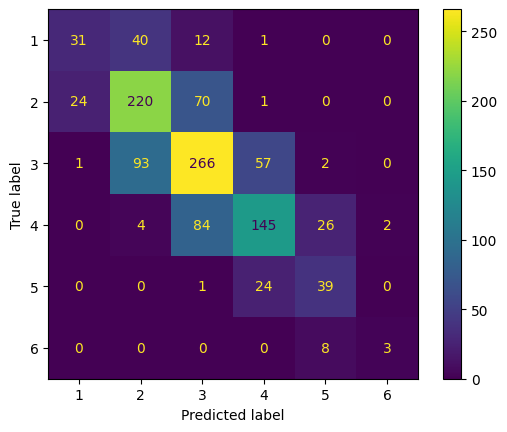

F1 score across fold: 0.6065017791330922
Cohen kappa score across fold: 0.7815965311600173
fold 9
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.732646	valid's QWK: 0.705823
[50]	train's QWK: 0.76045	valid's QWK: 0.737623
[75]	train's QWK: 0.774774	valid's QWK: 0.741818
[100]	train's QWK: 0.782832	valid's QWK: 0.742926
[125]	train's QWK: 0.791196	valid's QWK: 0.751201
[150]	train's QWK: 0.797723	valid's QWK: 0.754503
[175]	train's QWK: 0.803448	valid's QWK: 0.753352
[200]	train's QWK: 0.808708	valid's QWK: 0.754482
[225]	train's QWK: 0.813289	valid's QWK: 0.758634
[250]	train's QWK: 0.816525	valid's QWK: 0.758645
[275]	train's QWK: 0.819965	valid's QWK: 0.760469
[300]	train's QWK: 0.822353	valid's QWK: 0.75881
[325]	train's QWK: 0.825752	valid's QWK: 0.759203
[350]	train's QWK: 0.82948	valid's QWK: 0.759222
Early stopping, best iteration is:
[287]	train's QWK: 0.821407	valid's QWK: 0.763259
Evalua

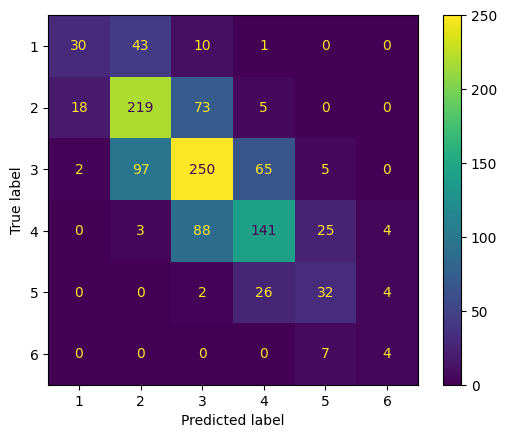

F1 score across fold: 0.5826191757395958
Cohen kappa score across fold: 0.7632593218285162
fold 10
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.730598	valid's QWK: 0.706061
[50]	train's QWK: 0.758478	valid's QWK: 0.732701
[75]	train's QWK: 0.772655	valid's QWK: 0.757456
[100]	train's QWK: 0.784756	valid's QWK: 0.762694
[125]	train's QWK: 0.791734	valid's QWK: 0.768648
[150]	train's QWK: 0.797547	valid's QWK: 0.775401
[175]	train's QWK: 0.802798	valid's QWK: 0.773278
[200]	train's QWK: 0.807075	valid's QWK: 0.772165
[225]	train's QWK: 0.812176	valid's QWK: 0.773253
Early stopping, best iteration is:
[150]	train's QWK: 0.797547	valid's QWK: 0.775401
Evaluated only: QWK


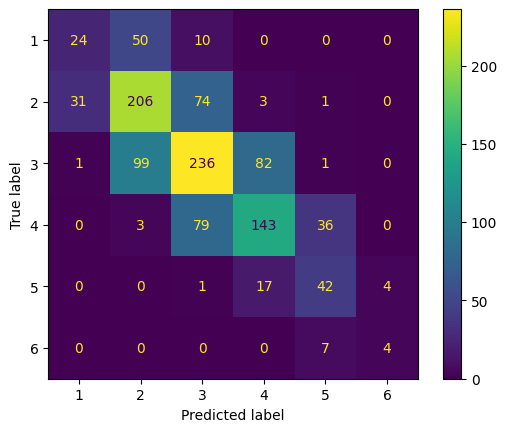

F1 score across fold: 0.5640112436675752
Cohen kappa score across fold: 0.7754013131060071
fold 11
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.731059	valid's QWK: 0.733392
[50]	train's QWK: 0.761523	valid's QWK: 0.75585
[75]	train's QWK: 0.774807	valid's QWK: 0.761219
[100]	train's QWK: 0.784151	valid's QWK: 0.762836
[125]	train's QWK: 0.791204	valid's QWK: 0.765505
[150]	train's QWK: 0.797585	valid's QWK: 0.763948
[175]	train's QWK: 0.80286	valid's QWK: 0.766975
[200]	train's QWK: 0.807194	valid's QWK: 0.769898
[225]	train's QWK: 0.810956	valid's QWK: 0.767866
[250]	train's QWK: 0.814712	valid's QWK: 0.769151
[275]	train's QWK: 0.819105	valid's QWK: 0.771116
[300]	train's QWK: 0.822815	valid's QWK: 0.772713
[325]	train's QWK: 0.826437	valid's QWK: 0.772696
[350]	train's QWK: 0.829392	valid's QWK: 0.772308
[375]	train's QWK: 0.832909	valid's QWK: 0.775291
Early stopping, best iteration is:
[313

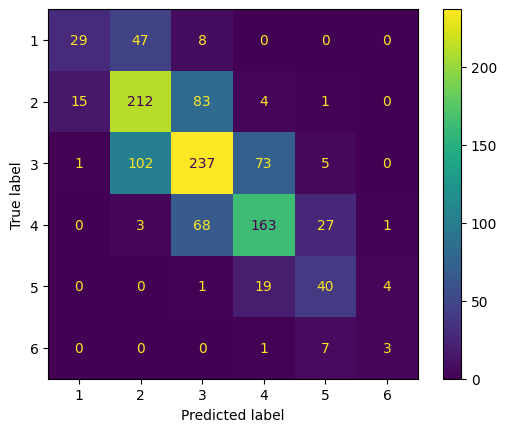

F1 score across fold: 0.5894531907222155
Cohen kappa score across fold: 0.7766914732522334
fold 12
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.732767	valid's QWK: 0.709411
[50]	train's QWK: 0.759294	valid's QWK: 0.735565
[75]	train's QWK: 0.775296	valid's QWK: 0.751487
[100]	train's QWK: 0.784213	valid's QWK: 0.762885
[125]	train's QWK: 0.791392	valid's QWK: 0.767091
[150]	train's QWK: 0.797258	valid's QWK: 0.77031
[175]	train's QWK: 0.802158	valid's QWK: 0.769243
[200]	train's QWK: 0.807046	valid's QWK: 0.774111
[225]	train's QWK: 0.811582	valid's QWK: 0.77466
[250]	train's QWK: 0.816053	valid's QWK: 0.771559
[275]	train's QWK: 0.819782	valid's QWK: 0.774786
[300]	train's QWK: 0.823347	valid's QWK: 0.776012
[325]	train's QWK: 0.826395	valid's QWK: 0.771661
[350]	train's QWK: 0.82965	valid's QWK: 0.775065
[375]	train's QWK: 0.833514	valid's QWK: 0.774853
[400]	train's QWK: 0.836172	valid's QWK:

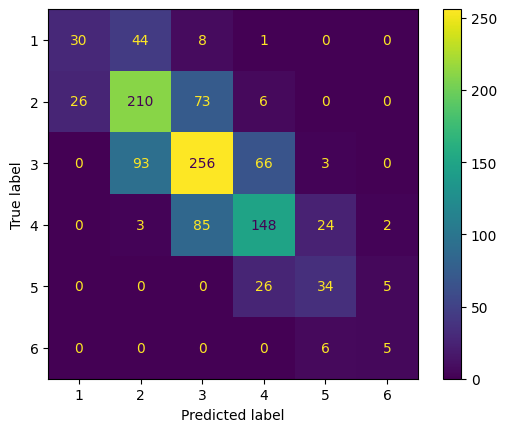

F1 score across fold: 0.5894147393724213
Cohen kappa score across fold: 0.7785122395292245
fold 13
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.731408	valid's QWK: 0.726553
[50]	train's QWK: 0.760747	valid's QWK: 0.747038
[75]	train's QWK: 0.774136	valid's QWK: 0.747717
[100]	train's QWK: 0.783038	valid's QWK: 0.752788
[125]	train's QWK: 0.790339	valid's QWK: 0.752863
[150]	train's QWK: 0.796571	valid's QWK: 0.751039
[175]	train's QWK: 0.802246	valid's QWK: 0.75384
[200]	train's QWK: 0.807574	valid's QWK: 0.757921
[225]	train's QWK: 0.812324	valid's QWK: 0.75923
[250]	train's QWK: 0.815265	valid's QWK: 0.763118
[275]	train's QWK: 0.819873	valid's QWK: 0.764411
[300]	train's QWK: 0.822345	valid's QWK: 0.765223
[325]	train's QWK: 0.826305	valid's QWK: 0.766288
[350]	train's QWK: 0.829822	valid's QWK: 0.767904
[375]	train's QWK: 0.832837	valid's QWK: 0.76888
[400]	train's QWK: 0.83564	valid's QWK: 

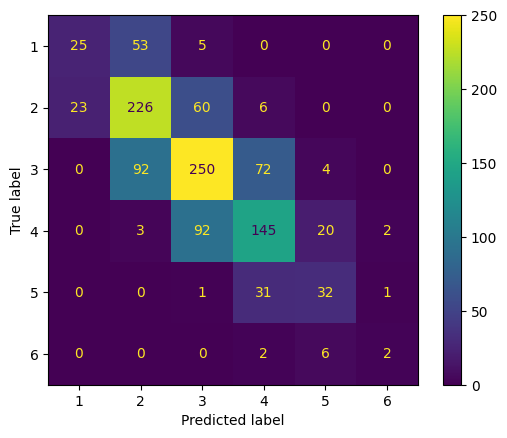

F1 score across fold: 0.5840897202972765
Cohen kappa score across fold: 0.7709527879629318
fold 14
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.731109	valid's QWK: 0.716192
[50]	train's QWK: 0.759501	valid's QWK: 0.739745
[75]	train's QWK: 0.775379	valid's QWK: 0.750783
[100]	train's QWK: 0.784869	valid's QWK: 0.755861
[125]	train's QWK: 0.793063	valid's QWK: 0.761321
[150]	train's QWK: 0.797552	valid's QWK: 0.763243
[175]	train's QWK: 0.803779	valid's QWK: 0.763812
[200]	train's QWK: 0.807942	valid's QWK: 0.76174
[225]	train's QWK: 0.812307	valid's QWK: 0.759953
Early stopping, best iteration is:
[172]	train's QWK: 0.802888	valid's QWK: 0.766448
Evaluated only: QWK


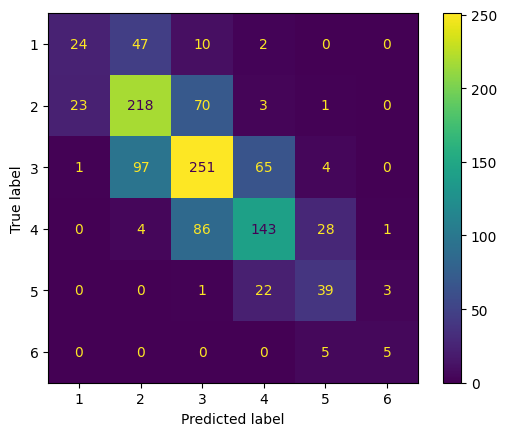

F1 score across fold: 0.585275123562793
Cohen kappa score across fold: 0.7664483837033582
fold 15
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.731688	valid's QWK: 0.72966
[50]	train's QWK: 0.759924	valid's QWK: 0.751259
[75]	train's QWK: 0.772985	valid's QWK: 0.760257
[100]	train's QWK: 0.782631	valid's QWK: 0.767291
[125]	train's QWK: 0.78829	valid's QWK: 0.765933
[150]	train's QWK: 0.796774	valid's QWK: 0.775022
[175]	train's QWK: 0.802846	valid's QWK: 0.774028
[200]	train's QWK: 0.807708	valid's QWK: 0.774802
[225]	train's QWK: 0.812086	valid's QWK: 0.774577
Early stopping, best iteration is:
[153]	train's QWK: 0.797554	valid's QWK: 0.776557
Evaluated only: QWK


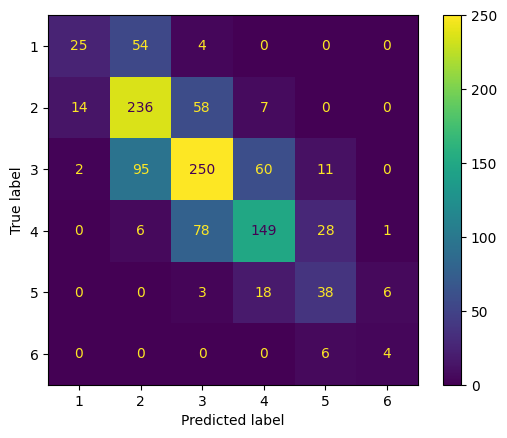

F1 score across fold: 0.6039621599632483
Cohen kappa score across fold: 0.7765572001638651
Mean F1 score across 15 folds: 0.5914721082308526
Mean Cohen kappa score across 15 folds: 0.7751750647159585


In [12]:
# Define the number of splits for cross-validation
n_splits = 15

# Initialize StratifiedKFold with the specified number of splits
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

# Lists to store scores
f1_scores = []
kappa_scores = []
models = []
predictions = []
callbacks = [log_evaluation(period=25), early_stopping(stopping_rounds=75,first_metric_only=True)]
# Loop through each fold of the cross-validation
i=1
for train_index, test_index in skf.split(X, y_split):
    # Split the data into training and testing sets for this fold
    print('fold',i)
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold, y_test_fold_int = y[train_index], y[test_index], y_split[test_index]
    
    model = lgb.LGBMRegressor(
                objective = qwk_obj,
                metrics = 'None',
                learning_rate = 0.1,
                max_depth = 5,
                num_leaves = 10,
                colsample_bytree=0.5,
                reg_alpha = 0.1,
                reg_lambda = 0.8,
                n_estimators=1024,
                random_state=42,
                extra_trees=True,
                class_weight='balanced',
                device='gpu',
                verbosity = - 1)

    # Fit the model on the training data for this fold
    
    predictor = model.fit(X_train_fold,
                                  y_train_fold,
                                  eval_names=['train', 'valid'],
                                  eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
                                  eval_metric=quadratic_weighted_kappa,
                                  callbacks=callbacks,)
    models.append(predictor)
    # Make predictions on the test data for this fold
    predictions_fold = predictor.predict(X_test_fold)
    predictions_fold = predictions_fold + a
    predictions_fold = predictions_fold.clip(1, 6).round()
    predictions.append(predictions_fold)
    # Calculate and store the F1 score for this fold
    f1_fold = f1_score(y_test_fold_int, predictions_fold, average='weighted')
    f1_scores.append(f1_fold)
    
    # Calculate and store the Cohen's kappa score for this fold
    kappa_fold = cohen_kappa_score(y_test_fold_int, predictions_fold, weights='quadratic')
    kappa_scores.append(kappa_fold)
    
    # Calculating the confusion matrix
    cm = confusion_matrix(y_test_fold_int, predictions_fold, labels=[x for x in range(1,7)])

    # Displaying the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[x for x in range(1,7)])
    disp.plot()
    plt.show()
    print(f'F1 score across fold: {f1_fold}')
    print(f'Cohen kappa score across fold: {kappa_fold}')
    i+=1
# Calculate the mean scores across all folds
mean_f1_score = np.mean(f1_scores)
mean_kappa_score = np.mean(kappa_scores)

# Print the mean scores
print(f'Mean F1 score across {n_splits} folds: {mean_f1_score}')
print(f'Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')

### Inference

In [13]:
probabilities = []
for model in models:
    proba= model.predict(dstr_hidden['test']['hidden_state'].numpy())+ a
    probabilities.append(proba)
# Compute the average probabilities across all models
predictions = np.mean(probabilities, axis=0)

predictions = np.round(predictions.clip(1, 6))

# Print the predictions
print(predictions)


[2. 3. 4.]


In [14]:
submission=pd.read_csv("/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv")
submission['score']=predictions
submission['score']=submission['score'].astype(int)
submission.to_csv("submission.csv",index=None)
display(submission.head())

,essay_id,score
0,000d118,2
1,000fe60,3
2,001ab80,4
